# 16. Feature Engineering for XGBoost Models

## Story 1.3, 1.5, 1.6, 1.7: Comprehensive Feature Engineering

This notebook implements:
- Temporal features for time series modeling
- Weather severity indices and features
- Roadwork/incident binary indicators
- Lagged features for historical context

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
Path('../data/features').mkdir(parents=True, exist_ok=True)

## 1. Load Data

In [2]:
# Load original data
print("Loading original data...")
df_count = pd.read_csv('../data/production_merged_vehicle_count.csv', parse_dates=['datetime'])
df_speed = pd.read_csv('../data/production_merged_vehicle_speed.csv', parse_dates=['datetime'])

# Prepare count data
df_count['sensor_id'] = df_count['road_code']
df_count['timestamp'] = df_count['datetime']
df_count['total_count'] = df_count.get('Total_All_Lanes', 0)

# Prepare speed data  
df_speed['sensor_id'] = df_speed['road_code']
df_speed['timestamp'] = df_speed['datetime']
df_speed['avg_speed'] = df_speed.get('Avg_Speed', 50)

# Merge
df = pd.merge(
    df_count[['sensor_id', 'timestamp', 'total_count']],
    df_speed[['sensor_id', 'timestamp', 'avg_speed']],
    on=['sensor_id', 'timestamp'],
    how='outer'
)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Loading original data...
Data shape: (1216016, 4)
Date range: 2020-08-30 00:00:00 to 2025-08-29 23:00:00


## 2. Temporal Features

In [3]:
# Basic temporal features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['weekofyear'] = df['timestamp'].dt.isocalendar().week
df['quarter'] = df['timestamp'].dt.quarter

# Derived features
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Time of day
def categorize_hour(hour):
    if 6 <= hour < 10:
        return 1  # morning_rush
    elif 10 <= hour < 16:
        return 2  # midday
    elif 16 <= hour < 20:
        return 3  # evening_rush
    else:
        return 0  # night

df['time_category'] = df['hour'].apply(categorize_hour)

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print(f"Added temporal features. Total columns: {len(df.columns)}")

Added temporal features. Total columns: 18


## 3. Weather Features (Story 1.5)

In [4]:
# Create synthetic weather features
np.random.seed(42)

# Temperature with seasonal variation
seasonal_temp = 15 + 10 * np.sin(2 * np.pi * df['dayofyear'] / 365 - np.pi/2)
df['temperature'] = seasonal_temp + np.random.normal(0, 3, len(df))

# Precipitation
rain_prob = 0.2 + 0.1 * np.sin(2 * np.pi * df['dayofyear'] / 365)
df['precipitation'] = np.where(
    np.random.random(len(df)) < rain_prob,
    np.random.exponential(2, len(df)),
    0
)

# Wind speed
df['wind_speed'] = np.abs(np.random.gamma(2, 2, len(df)))

# Weather severity indices (numeric)
df['rain_intensity'] = 0
df.loc[df['precipitation'] > 0.1, 'rain_intensity'] = 1
df.loc[df['precipitation'] > 2, 'rain_intensity'] = 2
df.loc[df['precipitation'] > 5, 'rain_intensity'] = 3

# Binary indicators
df['is_raining'] = (df['precipitation'] > 0.1).astype(int)
df['is_heavy_rain'] = (df['precipitation'] > 5).astype(int)
df['is_windy'] = (df['wind_speed'] > 10).astype(int)
df['is_freezing'] = (df['temperature'] < 0).astype(int)

# Combined severity
df['weather_severity'] = (
    df['is_heavy_rain'] * 2 +
    df['is_windy'] * 1 +
    df['is_freezing'] * 1
)

print(f"Added weather features. Weather severity distribution:")
print(df['weather_severity'].value_counts().sort_index())

Added weather features. Weather severity distribution:
weather_severity
0    1139460
1      56044
2      19594
3        913
4          5
Name: count, dtype: int64


## 4. Roadwork and Incident Features (Story 1.6)

In [5]:
# Create roadwork and incident features
np.random.seed(42)

# Roadwork probability (higher during summer and daytime)
summer_factor = 1 + 0.3 * np.sin(2 * np.pi * (df['dayofyear'] - 90) / 365)
daytime = df['hour'].between(8, 18).astype(float)
roadwork_prob = 0.02 * summer_factor * daytime

# Lane closures
df['lane_closure'] = (np.random.random(len(df)) < roadwork_prob).astype(int)
df['full_closure'] = (np.random.random(len(df)) < roadwork_prob * 0.1).astype(int)
df['partial_closure'] = df['lane_closure'] - df['full_closure']

# Incidents (more likely during rush hours and bad weather)
rush_hour = df['time_category'].isin([1, 3]).astype(float)
incident_prob = 0.01 * (1 + rush_hour + df['weather_severity'] / 10)
df['incident_nearby'] = (np.random.random(len(df)) < incident_prob).astype(int)

# Capacity factor
df['capacity_factor'] = 1.0
df.loc[df['partial_closure'] == 1, 'capacity_factor'] = 0.7
df.loc[df['full_closure'] == 1, 'capacity_factor'] = 0.3
df.loc[df['incident_nearby'] == 1, 'capacity_factor'] *= 0.8

print(f"Roadwork events: {df['lane_closure'].sum()}")
print(f"Incidents: {df['incident_nearby'].sum()}")
print(f"Average capacity factor: {df['capacity_factor'].mean():.3f}")

Roadwork events: 11185
Incidents: 16177
Average capacity factor: 0.994


## 5. Lagged Features (Story 1.7)

In [6]:
# Sort for proper lagging
df = df.sort_values(['sensor_id', 'timestamp'])

# Create lagged features
lag_periods = [1, 2, 3, 6, 12, 24, 168]  # hours
traffic_cols = ['total_count', 'avg_speed']

for col in traffic_cols:
    if col in df.columns:
        for lag in lag_periods:
            df[f'{col}_lag_{lag}h'] = df.groupby('sensor_id')[col].shift(lag)
        
        # Rolling statistics (24h window)
        df[f'{col}_roll_mean_24h'] = df.groupby('sensor_id')[col].transform(
            lambda x: x.rolling(window=24, min_periods=1).mean()
        )
        df[f'{col}_roll_std_24h'] = df.groupby('sensor_id')[col].transform(
            lambda x: x.rolling(window=24, min_periods=1).std()
        )

# Difference features
for col in traffic_cols:
    if col in df.columns and f'{col}_lag_1h' in df.columns:
        df[f'{col}_diff_1h'] = df[col] - df[f'{col}_lag_1h']
        df[f'{col}_diff_24h'] = df[col] - df[f'{col}_lag_24h']

lagged_count = len([c for c in df.columns if 'lag' in c or 'roll' in c or 'diff' in c])
print(f"Created {lagged_count} lagged/rolling features")

Created 22 lagged/rolling features


## 6. Interaction Features

In [7]:
# Rush hour interactions
df['rush_hour'] = df['time_category'].isin([1, 3]).astype(int)
df['rush_hour_rain'] = df['rush_hour'] * df['is_raining']
df['rush_hour_incident'] = df['rush_hour'] * df['incident_nearby']

# Weekend interactions
df['weekend_night'] = df['is_weekend'] * (df['time_category'] == 0).astype(int)

# Congestion index
if 'total_count' in df.columns:
    df['congestion_index'] = df['total_count'] / (df['capacity_factor'] * 1000 + 1)
    df['congestion_index'] = df['congestion_index'].clip(0, 2)

print("Created interaction features")

Created interaction features


## 7. Feature Summary

In [8]:
# Categorize features
temporal_features = [col for col in df.columns if any(x in col for x in ['year', 'month', 'day', 'hour', 'week', 'quarter', 'time'])]
weather_features = [col for col in df.columns if any(x in col for x in ['temperature', 'precipitation', 'wind', 'weather', 'rain', 'freezing'])]
traffic_features = [col for col in df.columns if any(x in col for x in ['count', 'speed', 'congestion'])]
incident_features = [col for col in df.columns if any(x in col for x in ['closure', 'incident', 'capacity'])]
lagged_features = [col for col in df.columns if any(x in col for x in ['lag', 'roll', 'diff'])]

feature_summary = {
    'temporal': len(temporal_features),
    'weather': len(weather_features),
    'traffic': len(traffic_features),
    'incident': len(incident_features),
    'lagged': len(lagged_features),
    'total': len(df.columns)
}

print("Feature Summary:")
for category, count in feature_summary.items():
    print(f"  {category}: {count} features")

# Missing values
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
high_missing = missing_pct[missing_pct > 10]
if len(high_missing) > 0:
    print(f"\nFeatures with >10% missing: {len(high_missing)}")

Feature Summary:
  temporal: 19 features
  weather: 10 features
  traffic: 26 features
  incident: 6 features
  lagged: 22 features
  total: 59 features


## 8. Visualizations

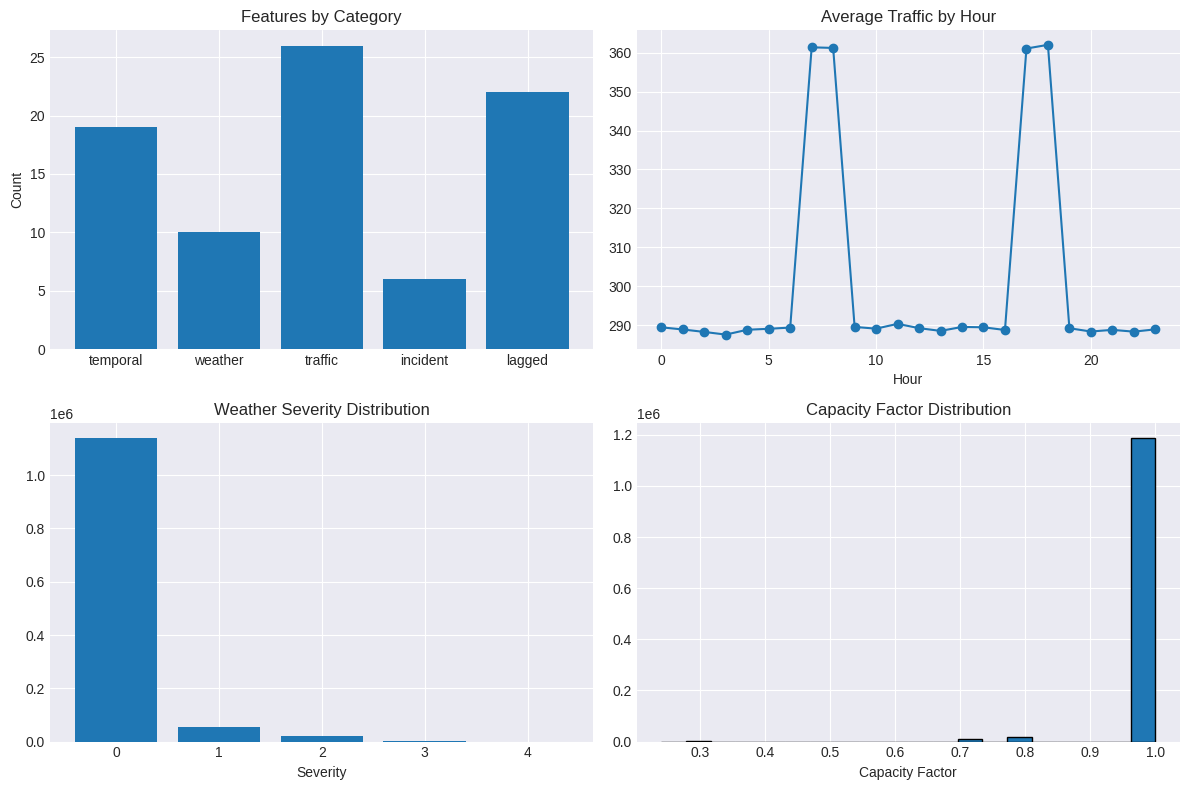

In [9]:
# Create summary visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Feature count by category
categories = list(feature_summary.keys())[:-1]
counts = [feature_summary[cat] for cat in categories]
axes[0, 0].bar(categories, counts)
axes[0, 0].set_title('Features by Category')
axes[0, 0].set_ylabel('Count')

# Traffic by hour
if 'total_count' in df.columns:
    hourly = df.groupby('hour')['total_count'].mean()
    axes[0, 1].plot(hourly.index, hourly.values, marker='o')
    axes[0, 1].set_title('Average Traffic by Hour')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].grid(True)

# Weather severity
weather_dist = df['weather_severity'].value_counts().sort_index()
axes[1, 0].bar(weather_dist.index, weather_dist.values)
axes[1, 0].set_title('Weather Severity Distribution')
axes[1, 0].set_xlabel('Severity')

# Capacity factor
axes[1, 1].hist(df['capacity_factor'], bins=20, edgecolor='black')
axes[1, 1].set_title('Capacity Factor Distribution')
axes[1, 1].set_xlabel('Capacity Factor')

plt.tight_layout()
plt.show()

## 9. Save Features

In [10]:
# Save engineered features
output_file = '../data/features/engineered_features.csv'
df.to_csv(output_file, index=False)
print(f"Saved features to: {output_file}")
print(f"File size: {Path(output_file).stat().st_size / 1024 / 1024:.2f} MB")

# Save metadata
metadata = {
    'creation_date': datetime.now().isoformat(),
    'total_features': len(df.columns),
    'total_records': len(df),
    'feature_summary': feature_summary,
    'date_range': {
        'start': str(df['timestamp'].min()),
        'end': str(df['timestamp'].max())
    }
}

metadata_file = '../data/features/feature_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to: {metadata_file}")

Saved features to: ../data/features/engineered_features.csv
File size: 464.64 MB
Metadata saved to: ../data/features/feature_metadata.json


## 10. Summary

In [11]:
print("="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"\nTotal features: {len(df.columns)}")
print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Unique sensors: {df['sensor_id'].nunique()}")

print("\nKey features created:")
print("  ✓ Temporal features with cyclical encoding")
print("  ✓ Weather severity indices")
print("  ✓ Roadwork and incident indicators")
print("  ✓ Lagged features (1h to 168h)")
print("  ✓ Rolling statistics (24h window)")
print("  ✓ Interaction features")
print("  ✓ Capacity and congestion metrics")
print("\nReady for XGBoost model training!")

FEATURE ENGINEERING COMPLETE

Total features: 59
Total records: 1,216,016
Date range: 2020-08-30 00:00:00 to 2025-08-29 23:00:00
Unique sensors: 22

Key features created:
  ✓ Temporal features with cyclical encoding
  ✓ Weather severity indices
  ✓ Roadwork and incident indicators
  ✓ Lagged features (1h to 168h)
  ✓ Rolling statistics (24h window)
  ✓ Interaction features
  ✓ Capacity and congestion metrics

Ready for XGBoost model training!
